# Basic Setup and Cleaning
From previous assignment

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from ast import literal_eval
import math
import geopandas as gpd


# maps
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

dogs = pd.read_csv("../input/dogsdataprecleaning/1dogs.csv", index_col=0)
pd.set_option("display.max_rows", 5)
dogs.head()

df = dogs.reset_index()
df

df['Location_masked'] = [literal_eval(x) for x in df['Location_masked']]
df['Latitude_masked']=df['Location_masked'].str[0]
df['Longitude_masked']=df['Location_masked'].str[1]
df

del df['Location_masked']
df
df.isna().any()


def get_distance(test_a, test_b):
    return math.hypot(test_b[0] - test_a[0], test_b[1] - test_a[1])
    
    
def get_neighborhood(lat, lng):
    neighborhoods = {
        "East Cambridge": [42.369204, -71.079015], 
        "Area 2/MIT": [42.359145, -71.094415], 
        "Wellington-Harrington": [42.371264, -71.092608], 
        "The Port": [42.365604, -71.09691],
        "Cambridgeport": [42.3586, -71.109293], 
        "Mid-Cambridge": [42.372655, -71.108721],
        "Riverside": [42.36757, -71.1136],
        "Agassiz": [42.380667, -71.116386],
        "Neighborhood Nine": [42.386545, -71.127079],
        "West Cambridge": [42.376936, -71.136375],
        "North Cambridge": [42.394835, -71.132134],
        "Cambridge Highlands": [42.390774, -71.149859],
        "Strawberry Hill": [42.37938, -71.152475]
    }
    
    tmp = "East Cambridge"

    for neighborhood in neighborhoods:
        p = neighborhoods[neighborhood]
        q = [lat, lng]
        distance = get_distance(p, q)
        if distance < get_distance(neighborhoods[tmp], q):
            tmp = neighborhood
    
    return tmp

get_neighborhood(df.Latitude_masked[22], df.Longitude_masked[22]) 


df['Neighborhood'] = df.apply(
    lambda row: get_neighborhood(row['Latitude_masked'], row['Longitude_masked'])  if pd.isnull(row['Neighborhood']) else row['Neighborhood'],
    axis=1
)


df.isna().any()

def get_popular_breeds(nhood):
    h = list(dogs.loc[dogs["Neighborhood"] == nhood, "Dog_Breed"].value_counts().to_dict().items())
    sortedList = sorted(h, key=lambda k: (-k[1], k[0]))
    temp_list = [i[0] for i in sortedList]
    return temp_list


for nhood in list(pd.unique(dogs['Neighborhood'])):    
    counter = 0
    tmp_list = get_popular_breeds(nhood)
    for dog in df.index[df['Dog_Breed'].isnull()]:
        if dog in df.index[df['Neighborhood'] == nhood]:
            df.at[dog,'Dog_Breed'] = tmp_list[counter]
            counter += 1

df['Dog_Name'].fillna("Poopsy", inplace=True)
df.isna().sum()

df

/kaggle/input/dogsdataprecleaning/1dogs.csv
/kaggle/input/cleanedexample/clean_dogs_reference.csv


Dog_Name         Dog_Breed  Latitude_masked  Longitude_masked  \
0        Ella  Golden Retriever        42.381385        -71.109633   
1       Nalah               Mix        42.374769        -71.096900   
...       ...               ...              ...               ...   
5069     Nien          Shih Tzu        42.370491        -71.088527   
5070   Ramses  Alaskan Klee Kai        42.370484        -71.102222   

               Neighborhood  
0                   Agassiz  
1     Wellington-Harrington  
...                     ...  
5069  Wellington-Harrington  
5070          Mid-Cambridge  

[5071 rows x 5 columns]

# Folium Heatmap

First, using Foliumn, we create a basic heatmmap illustrating which parts of Cambridge have the most dogs. As one can also tell by looking at the heatmap, there are not any dogs with address in Fresh Pond or Harvard Yard. This makes sense. 

In [2]:
# Create a base map
m_5 = folium.Map(location=[42.378778, -71.120306], tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
HeatMap(data=df[['Latitude_masked', 'Longitude_masked']], radius=10).add_to(m_5)

# Display the map
m_5

# Folium Clsuter Map
This map, also made using Folium, clsters points together based on their location. This helps users view where, approximately. dogs are located while getting a general sense of the distribution of dogs in Cambridge.

In [3]:
# Create the map
m_3 = folium.Map(location=[42.378778, -71.120306], tiles='cartodbpositron', zoom_start=13)

# Add points to the map
mc = MarkerCluster()
for idx, row in df.iterrows():
    if not math.isnan(row['Longitude_masked']) and not math.isnan(row['Latitude_masked']):
        mc.add_child(Marker([row['Latitude_masked'], row['Longitude_masked']], popup=row['Dog_Name']))
m_3.add_child(mc)

# Display the map
m_3

# Plotly Test Tree
Now, with Plotly, we get interactive rectangular boxes that also tell us the distribution of dog breeds in the 13 Cambridge neighborhoods.

In [4]:
import plotly.express as px
import plotly.graph_objects as go

new = pd.crosstab(df.Dog_Breed,df.Neighborhood)

genre = list(new.index)
genre
count = list(new.Cambridgeport)

names = ['Agassiz', 'A2', 'Highlands', 'Cambridgeport', 'East', 'Mid', 'Nine', 'North', 'Riverside', 'Strawberry', 'Port', "WH", 'West']

new.columns = names
new

namesHood = ['list(new.Agassiz)', 'list(new.A2)', 'list(new.Highlands)', 'list(new.Cambridgeport)', 'list(new.East)', 'list(new.Mid)', 'list(new.Nine)', 'list(new.North)', 'list(new.Riverside)', 'list(new.Strawberry)', 'list(new.Port)', "list(new.WH)", 'list(new.West)']


for hood in namesHood:
    test_tree = go.Figure(go.Treemap(
        labels =  genre,
        parents=[""]*len(genre),
        values =  eval(hood),
        textinfo = "label+value"
    ))

    test_tree.show()
    
    

# Scatterplot
This is pretty similar to my first visualization--the heatmap; it illustrates each dog as a dot and lets you know that generally, you can find dogs across the different parts of Cambridge.

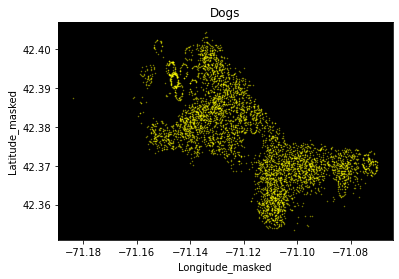

In [5]:
f, (ax1) = plt.subplots(1)

df.plot(kind='scatter', x='Longitude_masked', y='Latitude_masked',
                color='yellow', 
                s=.22, alpha=.5, subplots=False, ax=ax1)
ax1.set_title("Dogs")
ax1.set_facecolor('black')